사진을 넣어주세요


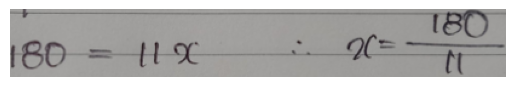


latex 문을 출력중입니다...

손글씨입니다

1줄 짜리 텍스트입니다.


$ 180=11 x \quad \therefore x=\frac {180}{11} $



In [4]:
from PIL import Image
import torch
import glob
import numpy as np
from transformers import (
DonutProcessor,
VisionEncoderDecoderConfig,
VisionEncoderDecoderModel,
)
import easyocr
import matplotlib.pyplot as plt
import json
import re



class LatexGenerator:
    def __init__(self, pretrained_path, img_paths):
        self.pretrained_path = pretrained_path
        self.img_paths = img_paths
        self.reader = easyocr.Reader(['en', 'ko'], gpu=True)
        self.config = None
        self.processor = None
        self.model = None
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.initialize()

    def initialize(self):
        self.processor = DonutProcessor.from_pretrained(self.pretrained_path+'processor')
        self.config = VisionEncoderDecoderConfig.from_pretrained(self.pretrained_path+'config')
        self.model = VisionEncoderDecoderModel.from_pretrained(self.pretrained_path+'model', config=self.config)
        self.model.to(self.device)
        self.model.eval()
        

    def generate_latex(self):
            length = 0
            limit = 0
            img_path = self.img_paths
            
            result = self.reader.readtext(str(img_path), detail=0, allowlist=None, blocklist=None, width_ths=0.1,
                         height_ths=0.1, text_threshold=0.7, low_text=0.3,
                         link_threshold=0.1, canvas_size=2560, mag_ratio=1.5, slope_ths=0.2,
                         ycenter_ths=0.5, add_margin=0.1, output_format='dict')
        
            for i in result:
                for j in i:
                    if isinstance(j, str):
                        length += len(j)
            
            length *=  2
            
            if length < 5:
                length = 5
            
            sample_test_img = Image.open(img_path).convert("RGB")
            sample_test_img = sample_test_img.resize((480, 480))

            pixel_values = self.processor(sample_test_img, random_padding=True).pixel_values
            pixel_values = torch.FloatTensor(pixel_values).to(self.device)
            
            decoder_input_ids = torch.full(
                (1, 1),
                self.model.config.decoder_start_token_id,
                device=self.device,
            )
            
            outputs = self.model.generate(
            pixel_values,
            decoder_input_ids=decoder_input_ids,
            max_length=length,
            early_stopping=True,
            pad_token_id=self.processor.tokenizer.pad_token_id,
            eos_token_id=self.processor.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,
            top_k=1,
            bad_words_ids=[[self.processor.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
            )
            
            tmp = self.processor.tokenizer.batch_decode(outputs.sequences)[0].replace(' ','')[:34]
            Line_no = 1
            
            length //=  2
            
            if '<hand>' in tmp: # 손글씨일 때 augmentated model 사용
                flag = True
            else:
                flag = False
            print('\nlatex 문을 출력중입니다...\n')
            if flag:
                print('손글씨입니다\n')
                tmp_path = '/home/ubuntu/kr-img2latex/pretrained/main/test_model/'
                processor = DonutProcessor.from_pretrained(tmp_path+'processor')
                config = VisionEncoderDecoderConfig.from_pretrained(tmp_path+'config')
                model = VisionEncoderDecoderModel.from_pretrained(tmp_path+'model', config=config)
                model.to(self.device)
                model.eval()
                try:
                    Line_no = int(re.findall(r'\d+', tmp)[0])
                except:
                    Line_no = 1
                print(f'{Line_no}줄 짜리 텍스트입니다.\n')
                while True:
                    flag1 = False  # '</latex>'
                    flag2 = False  # '<line>'
                    Line = 0
                    outputs = model.generate(
                        pixel_values,
                        decoder_input_ids=decoder_input_ids,
                        max_length=length,
                        early_stopping=True,
                        pad_token_id=processor.tokenizer.pad_token_id,
                        eos_token_id=processor.tokenizer.eos_token_id,
                        use_cache=True,
                        num_beams=1,
                        top_k=1,
                        bad_words_ids=[[processor.tokenizer.unk_token_id]],
                        return_dict_in_generate=True,
                    )
                    x = processor.tokenizer.batch_decode(outputs.sequences)[0]

                    for i, j in enumerate(x):
                        if x[i:i+7] == '</line>':
                            Line += 1

                    if Line >= Line_no:
                        break

                    elif limit >= 50:
                        break
                    else:
                        if int(length * 0.02) <= 1:
                            length += 1
                    limit += 1
                    length = int(length * 1.02)

                outputs = model.generate(
                        pixel_values,
                        decoder_input_ids=decoder_input_ids,
                        max_length=length,
                        early_stopping=True,
                        pad_token_id=processor.tokenizer.pad_token_id,
                        eos_token_id=processor.tokenizer.eos_token_id,
                        use_cache=True,
                        num_beams=1,
                        top_k=1,
                        bad_words_ids=[[processor.tokenizer.unk_token_id]],
                        return_dict_in_generate=True,
                )
                latex_output = processor.tokenizer.batch_decode(outputs.sequences)[0]

                return latex_output
            else: # 인쇄체일 때 default model 사용
                try:
                    Line_no = int(re.findall(r'\d+', tmp)[0])
                except:
                    Line_no = 1
                print(f'{Line_no}줄 짜리 텍스트입니다.\n')
                print('인쇄체입니다\n')
                while True:
                    flag1 = False  # '</latex>'
                    flag2 = False  # '<line>'
                    Line = 0
                    outputs = self.model.generate(
                        pixel_values,
                        decoder_input_ids=decoder_input_ids,
                        max_length=length,
                        early_stopping=True,
                        pad_token_id=self.processor.tokenizer.pad_token_id,
                        eos_token_id=self.processor.tokenizer.eos_token_id,
                        use_cache=True,
                        num_beams=1,
                        top_k=1,
                        bad_words_ids=[[self.processor.tokenizer.unk_token_id]],
                        return_dict_in_generate=True,
                    )
                    x = self.processor.tokenizer.batch_decode(outputs.sequences)[0]

                    for i, j in enumerate(x):
                        if x[i:i+7] == '</line>':
                             Line += 1

                    if Line >= Line_no:
                        break

                    elif limit >= 50:
                        break
                    else:
                        if int(length * 0.02) <= 1:
                            length += 1
                    limit += 1
                    length = int(length * 1.02)

                outputs = self.model.generate(
                        pixel_values,
                        decoder_input_ids=decoder_input_ids,
                        max_length=length,
                        early_stopping=True,
                        pad_token_id=self.processor.tokenizer.pad_token_id,
                        eos_token_id=self.processor.tokenizer.eos_token_id,
                        use_cache=True,
                        num_beams=1,
                        top_k=1,
                        bad_words_ids=[[self.processor.tokenizer.unk_token_id]],
                        return_dict_in_generate=True,
                )
                latex_output = self.processor.tokenizer.batch_decode(outputs.sequences)[0]

                return latex_output
                
        
def text_to_json(text):
    json_result = {
        "text": text
    }
    return json.dumps(json_result)
        
def main():
    pretrained_path = "/home/ubuntu/kr-img2latex/pretrained/main/epoch-3, batch-8, img_size-480, max_length-256, line_len/"
    print('사진을 넣어주세요')
    test_img_paths = glob.glob('/home/ubuntu/kr-img2latex/data/test/images/*.png')
    sample_test_img_path = np.random.choice(test_img_paths)
    sample_test_json_file = sample_test_img_path.replace('images', 'annotations').replace('.png', '.json')
    img = plt.imread(sample_test_img_path)
    #sample_test_img_path = '/home/ubuntu/kr-img2latex/data/test/fortest.png'
    #img = plt.imread(sample_test_img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    latex_gen = LatexGenerator(pretrained_path, sample_test_img_path)
    output = latex_gen.generate_latex()
    output = output.replace('<one>', '1').replace('<TPT><TPT>', '').replace('</s>', '').replace('</line>', '\n').replace('<line>', '').replace('<print>', '').replace('<hand>', '')
    output = output.replace('<latex>', '$').replace('</latex>', ' $')
    output = re.sub(r"<len>.*?</len>", "", output)
    print('')
    print(output)
    output = text_to_json(output)
    return output

if __name__ == "__main__":
    main()